In [ ]:
import os
import cv2
from PIL import Image
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
from torchvision.models import MobileNet_V2_Weights

dataset_dir = "/home/mostafabakr/Desktop/Project X/img data"  
video_dataset_dir = "/home/mostafabakr/Desktop/Project X/vid data"  
frame_output_dir = "/home/mostafabakr/Desktop/Project X/Test_img/frames"  
save_image_model_path = "/home/mostafabakr/Desktop/Project X/models/asl_image_model.pth"
save_video_model_path = "/home/mostafabakr/Desktop/Project X/models/asl_video_model.pth"
img_size = 224
batch_size = 16
num_epochs = 50
learning_rate = 0.0001
validation_split = 0.2
patience = 5
frame_rate = 60  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


def train_model(dataset_dir, save_model_path):
    if not os.path.exists(dataset_dir):
        raise FileNotFoundError(f"Dataset directory '{dataset_dir}' not found.")
    
    dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)
    val_size = int(len(dataset) * validation_split)
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    class_names = dataset.classes
    num_classes = len(class_names)

    weights = MobileNet_V2_Weights.IMAGENET1K_V1
    model = models.mobilenet_v2(weights=weights)
    model.classifier[1] = nn.Linear(model.last_channel, num_classes)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    best_val_accuracy = 0.0
    early_stop_counter = 0

    print("Starting training...")
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total * 100

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = val_correct / val_total * 100

        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

        scheduler.step()

    torch.save(model.state_dict(), save_model_path)
    print(f"Training complete. Model saved to {save_model_path}")

def extract_frames(video_dataset_dir, output_dir, frame_rate=60):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for label_dir in os.listdir(video_dataset_dir):
        label_path = os.path.join(video_dataset_dir, label_dir)
        output_label_dir = os.path.join(output_dir, label_dir)
        os.makedirs(output_label_dir, exist_ok=True)

        for video_file in os.listdir(label_path):
            video_path = os.path.join(label_path, video_file)
            cap = cv2.VideoCapture(video_path)
            frame_count = 0

            while True:
                ret, frame = cap.read()
                if not ret:
                    break

                if frame_count % frame_rate == 0:
                    frame_filename = os.path.join(
                        output_label_dir, f"{os.path.splitext(video_file)[0]}_frame_{frame_count}.jpg"
                    )
                    cv2.imwrite(frame_filename, frame)
                frame_count += 1

            cap.release()

    print("Frame extraction complete.")



if __name__ == "__main__":
    train_model(dataset_dir, save_image_model_path)

    extract_frames(video_dataset_dir, frame_output_dir)
    train_model(frame_output_dir, save_video_model_path)


Using device: cuda
Starting training...
Epoch 1/50
  Train Loss: 0.1169, Train Accuracy: 97.47%
  Val Loss: 0.0152, Val Accuracy: 99.53%
Epoch 2/50
  Train Loss: 0.0174, Train Accuracy: 99.52%
  Val Loss: 0.0086, Val Accuracy: 99.78%
Epoch 3/50
  Train Loss: 0.0103, Train Accuracy: 99.72%
  Val Loss: 0.0074, Val Accuracy: 99.78%
Epoch 4/50
  Train Loss: 0.0086, Train Accuracy: 99.77%
  Val Loss: 0.0103, Val Accuracy: 99.67%
Epoch 5/50
  Train Loss: 0.0081, Train Accuracy: 99.77%
  Val Loss: 0.0055, Val Accuracy: 99.84%
Epoch 6/50
  Train Loss: 0.0012, Train Accuracy: 99.98%
  Val Loss: 0.0035, Val Accuracy: 99.90%
Epoch 7/50
  Train Loss: 0.0003, Train Accuracy: 100.00%
  Val Loss: 0.0031, Val Accuracy: 99.92%
Epoch 8/50
  Train Loss: 0.0002, Train Accuracy: 100.00%
  Val Loss: 0.0034, Val Accuracy: 99.90%
Epoch 9/50
  Train Loss: 0.0001, Train Accuracy: 100.00%
  Val Loss: 0.0031, Val Accuracy: 99.92%
Epoch 10/50
  Train Loss: 0.0000, Train Accuracy: 100.00%
  Val Loss: 0.0033, Val Ac

[mjpeg @ 0x6199a2b81f00] overread 8
[mjpeg @ 0x6199a2b81f00] overread 8
[mjpeg @ 0x6199a2b81f00] overread 8
[mjpeg @ 0x6199ae8a3200] overread 8
[mjpeg @ 0x6199ae8a3200] overread 5
[mjpeg @ 0x6199ae8a3200] overread 8
[mjpeg @ 0x6199ae8a3200] overread 7
[mjpeg @ 0x6199ae8a3200] overread 8
[mjpeg @ 0x6199ae8a3200] overread 8
[mjpeg @ 0x6199ae8a3200] overread 8
[mjpeg @ 0x6199ae8a3200] overread 8
[mjpeg @ 0x6199ae8a3200] overread 6
[mjpeg @ 0x6199ae8a3200] overread 8
[mjpeg @ 0x6199ae8a3200] overread 8
[mjpeg @ 0x6199ae8a3200] overread 8
[mjpeg @ 0x6199ae8a3200] overread 8
[mjpeg @ 0x6199ae8a3200] overread 8
[mjpeg @ 0x6199ae8a3200] overread 8
[mjpeg @ 0x6199ae8a3200] overread 8
[mjpeg @ 0x6199ae8a3200] overread 8
[mjpeg @ 0x6199ae8a3200] overread 8
[mjpeg @ 0x6199ae8a3200] overread 4
[mjpeg @ 0x6199ae8a3200] overread 8
[mjpeg @ 0x6199ae8a3200] overread 8
[mjpeg @ 0x6199ae8a3200] overread 8
[mjpeg @ 0x6199ae8a3200] overread 8
[mjpeg @ 0x6199ae8a3200] overread 8
[mjpeg @ 0x6199ae8a3200] ove

Frame extraction complete.
Starting training...
Epoch 1/50
  Train Loss: 0.0804, Train Accuracy: 96.79%
  Val Loss: 0.0053, Val Accuracy: 99.91%
Epoch 2/50
  Train Loss: 0.0166, Train Accuracy: 99.47%
  Val Loss: 0.0013, Val Accuracy: 99.96%
Epoch 3/50
  Train Loss: 0.0107, Train Accuracy: 99.69%
  Val Loss: 0.0068, Val Accuracy: 99.82%
Epoch 4/50
  Train Loss: 0.0093, Train Accuracy: 99.63%
  Val Loss: 0.0007, Val Accuracy: 100.00%
Epoch 5/50
  Train Loss: 0.0023, Train Accuracy: 99.94%
  Val Loss: 0.0016, Val Accuracy: 99.96%
Epoch 6/50
  Train Loss: 0.0014, Train Accuracy: 99.94%
  Val Loss: 0.0001, Val Accuracy: 100.00%
Epoch 7/50
  Train Loss: 0.0004, Train Accuracy: 99.99%
  Val Loss: 0.0001, Val Accuracy: 100.00%
Epoch 8/50
  Train Loss: 0.0015, Train Accuracy: 99.97%
  Val Loss: 0.0001, Val Accuracy: 100.00%
Epoch 9/50
  Train Loss: 0.0002, Train Accuracy: 100.00%
  Val Loss: 0.0001, Val Accuracy: 100.00%
Early stopping triggered.
Training complete. Model saved to /home/mostafa

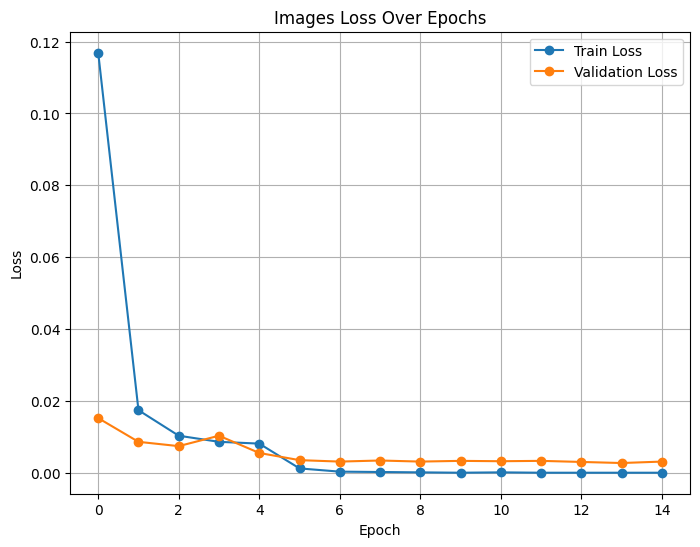

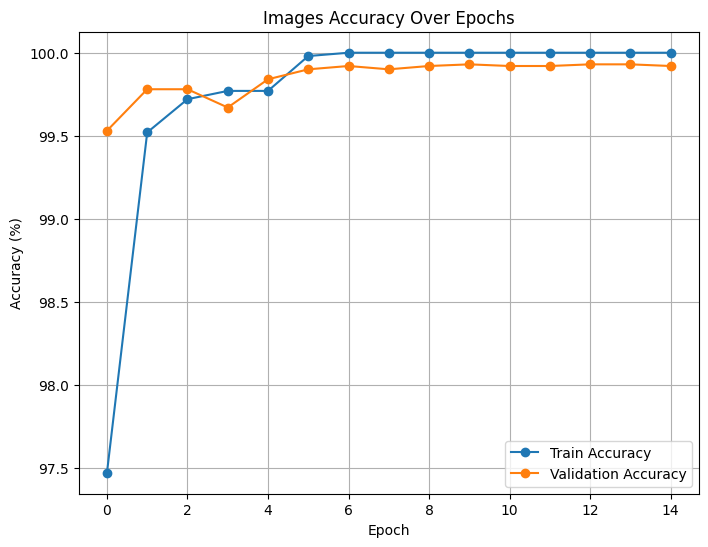

In [ ]:
import matplotlib.pyplot as plt

def plot_training(history):
    
    plt.figure(figsize=(8, 6))
    plt.plot(history['train_loss'], label='Train Loss', marker='o')
    plt.plot(history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Images Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(history['train_accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Images Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_training_vid(history):
    
    plt.figure(figsize=(8, 6))
    plt.plot(history['train_loss'], label='Train Loss', marker='o')
    plt.plot(history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Videos Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(history['train_accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Videos Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()




graph = {
    'train_loss': [
        0.1169, 0.0174, 0.0103, 0.0086, 0.0081, 
        0.0012, 0.0003, 0.0002, 0.0001, 0.0000, 
        0.0001, 0.0000, 0.0000, 0.0000, 0.0000
    ],
    'val_loss': [
        0.0152, 0.0086, 0.0074, 0.0103, 0.0055, 
        0.0035, 0.0031, 0.0034, 0.0031, 0.0033, 
        0.0032, 0.0033, 0.0030, 0.0027, 0.0031
    ],
    'train_accuracy': [
        97.47, 99.52, 99.72, 99.77, 99.77, 
        99.98, 100.00, 100.00, 100.00, 100.00, 
        100.00, 100.00, 100.00, 100.00, 100.00
    ],
    'val_accuracy': [
        99.53, 99.78, 99.78, 99.67, 99.84, 
        99.90, 99.92, 99.90, 99.92, 99.93, 
        99.92, 99.92, 99.93, 99.93, 99.92
    ]
}


plot_training(graph)

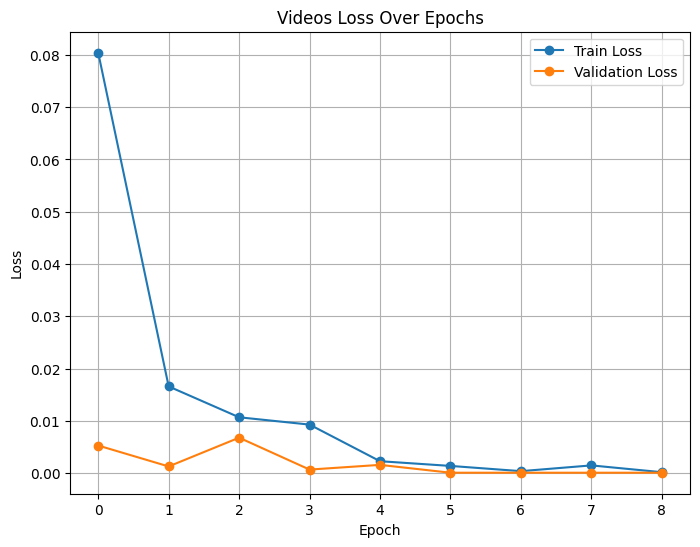

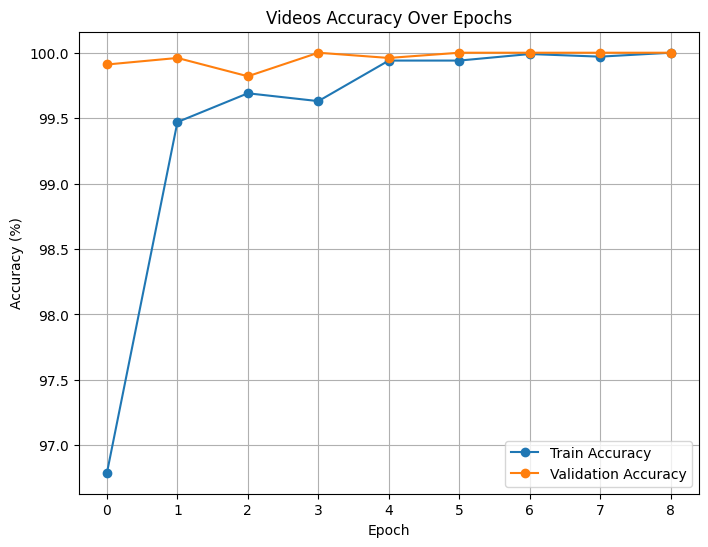

In [8]:
graph = {
    'train_loss': [
        0.0804, 0.0166, 0.0107, 0.0093, 0.0023, 0.0014, 0.0004, 0.0015, 0.0002
    ],
    'val_loss': [
        0.0053, 0.0013, 0.0068, 0.0007, 0.0016, 0.0001, 0.0001, 0.0001, 0.0001
    ],
    'train_accuracy': [
        96.79, 99.47, 99.69, 99.63, 99.94, 99.94, 99.99, 99.97, 100.00
    ],
    'val_accuracy': [
        99.91, 99.96, 99.82, 100.00, 99.96, 100.00, 100.00, 100.00, 100.00
    ]
}


plot_training_vid(graph)